<a href="https://colab.research.google.com/github/rahuldave/LearningJax/blob/main/Jax_GD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Machine Learning using Jax

This notebook is taken from 
_the [solving y=mx+b... with jax on a tpu pod slice](http://matpalm.com/blog/ymxb_pod_slice/) blog series_

Here we will fit a linear regression model using MSE. We'll do this both on a single device using `vmap` as well as across `num_replicas` devices. We'll make some sharding of the input data here in addition to the output data, so we can support a seamless Gradient Descent loop.

In [1]:
!cat /proc/cpuinfo

processor	: 0
vendor_id	: GenuineIntel
cpu family	: 6
model		: 79
model name	: Intel(R) Xeon(R) CPU @ 2.20GHz
stepping	: 0
microcode	: 0x1
cpu MHz		: 2199.998
cache size	: 56320 KB
physical id	: 0
siblings	: 2
core id		: 0
cpu cores	: 1
apicid		: 0
initial apicid	: 0
fpu		: yes
fpu_exception	: yes
cpuid level	: 13
wp		: yes
flags		: fpu vme de pse tsc msr pae mce cx8 apic sep mtrr pge mca cmov pat pse36 clflush mmx fxsr sse sse2 ss ht syscall nx pdpe1gb rdtscp lm constant_tsc rep_good nopl xtopology nonstop_tsc cpuid tsc_known_freq pni pclmulqdq ssse3 fma cx16 pcid sse4_1 sse4_2 x2apic movbe popcnt aes xsave avx f16c rdrand hypervisor lahf_lm abm 3dnowprefetch invpcid_single ssbd ibrs ibpb stibp fsgsbase tsc_adjust bmi1 hle avx2 smep bmi2 erms invpcid rtm rdseed adx smap xsaveopt arat md_clear arch_capabilities
bugs		: cpu_meltdown spectre_v1 spectre_v2 spec_store_bypass l1tf mds swapgs taa
bogomips	: 4399.99
clflush size	: 64
cache_alignment	: 64
address sizes	: 46 bits physical, 48 b

setup stuff for runtime TPU or CPU

In [2]:
USE_TPU = True

if USE_TPU:
  import jax
  import jax.tools.colab_tpu
  jax.tools.colab_tpu.setup_tpu()
else:
  # x8 cpu devices  
  import os
  os.environ["XLA_FLAGS"] = '--xla_force_host_platform_device_count=2'

In [3]:
import jax
print(repr(jax.devices()))
num_replicas = len(jax.devices())

[TpuDevice(id=0, process_index=0, coords=(0,0,0), core_on_chip=0), TpuDevice(id=1, process_index=0, coords=(0,0,0), core_on_chip=1), TpuDevice(id=2, process_index=0, coords=(1,0,0), core_on_chip=0), TpuDevice(id=3, process_index=0, coords=(1,0,0), core_on_chip=1), TpuDevice(id=4, process_index=0, coords=(0,1,0), core_on_chip=0), TpuDevice(id=5, process_index=0, coords=(0,1,0), core_on_chip=1), TpuDevice(id=6, process_index=0, coords=(1,1,0), core_on_chip=0), TpuDevice(id=7, process_index=0, coords=(1,1,0), core_on_chip=1)]


In [4]:
import numpy as np
import jax.numpy as jnp
import matplotlib.pyplot as plt
from jax import make_jaxpr

## 1: Generate some data

Let us generate some training data first. We'll add in some noise

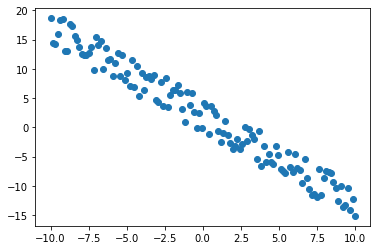

In [22]:
def y(x, m, b):
  return m * x + b

datasize = 128
x = np.linspace(-10, 10, num=datasize)
np.random.shuffle(x)

m_true = -1.5
b_true = 2.0

y_true = y(x, m_true, b_true)

noise = ((np.random.rand(*y_true.shape) * 2) - 1) * 3
y_true += noise

plt.plot(x, y_true, 'o')
plt.show()

Let us set up initial position in parameter space of (m, b). This initial point corresponds to a 45 degree line fot which is clearly bad.

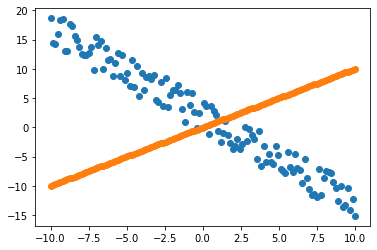

In [23]:
m_model = 1.0
b_model = 0.0

y_pred = y(x, m_model, b_model)
plt.plot(x, y_true, 'o')
plt.plot(x, y_pred, 'o')
plt.show()

## 2: Set up a loss function and get its gradient

We'll define our loss function in terms of our parameters, so that we can calulate the gradient with respect to them.

In [24]:
from jax import grad, jit

def sqr_loss(y_true, y_pred):
  return jnp.mean((y_true-y_pred)**2)

def loss_wrt_params(x, m, b, y_true):
  y_pred = y(x, m, b)
  return sqr_loss(y_true, y_pred)

# note: by dft grad calculates gradients w.r.t the first arg
#  but in this case we want it w.r.t. m & b, i.e. args 1 & 2
gradient_wrt_loss = jit(grad(loss_wrt_params, argnums=(1, 2)))


Notice the function composition. We jitted on the grad on the loss function. The `argnums=(1, 2)` describe which arguments are the parameters in the loss function `loss_wrt_params`. Here, the second and third arguments.

We can calculate the gradient at the true model parameters as well as the initial starting point in parameter space.

In [25]:
m_grad, b_grad = gradient_wrt_loss(x, m_true, b_true, y_true)
print("for true: m_grad", m_grad , "b_grad", b_grad)

m_grad, b_grad = gradient_wrt_loss(x, m_model, b_model, y_true)
print("for model params: m_grad", m_grad , "b_grad", b_grad)

for true: m_grad 0.8275 b_grad -0.06965329
for model params: m_grad 170.11884 b_grad -4.069654


Finally this gradient can be used in a for loop to implement gradient descent!

In [26]:
m, b = 1.0, 0.0
learning_rate = 0.01

print("true", m_true, b_true)
for _ in range(30):
  m_grad, b_grad = gradient_wrt_loss(x, m_model, b_model, y_true)
  m_model -= learning_rate * m_grad 
  b_model -= learning_rate * b_grad 
  print("grads", m_grad, b_grad , "=> model", m_model, b_model)

true -1.5 2.0
grads 170.11884 -4.069654 => model -0.7011883 0.04069654
grads 54.920258 -3.988261 => model -1.2503909 0.08057915
grads 17.730167 -3.908495 => model -1.4276925 0.119664095
grads 5.723911 -3.830325 => model -1.4849316 0.15796734
grads 1.8478823 -3.7537184 => model -1.5034105 0.19550453
grads 0.5965558 -3.678644 => model -1.509376 0.23229097
grads 0.19258726 -3.6050706 => model -1.5113019 0.26834166
grads 0.062177062 -3.5329704 => model -1.5119237 0.30367136
grads 0.020069182 -3.4623103 => model -1.5121244 0.33829445
grads 0.006476879 -3.393065 => model -1.5121891 0.3722251
grads 0.0020920038 -3.325204 => model -1.51221 0.40547714
grads 0.00067955256 -3.2586987 => model -1.5122168 0.43806413
grads 0.00022101402 -3.1935244 => model -1.5122191 0.46999937
grads 6.657839e-05 -3.1296546 => model -1.5122198 0.5012959
grads 1.8715858e-05 -3.0670617 => model -1.51222 0.53196657
grads 2.3245811e-06 -3.0057197 => model -1.51222 0.56202376
grads 1.7881393e-06 -2.9456053 => model -1.51

## 2: pytrees..making the model easier to write

If we were using a MLP instead of a linear regressor, we might have millions of parameters. We're not going to create millions of arguments. For this reason, jax provides a very nice concept of [`pytrees`](https://jax.readthedocs.io/en/latest/pytrees.html). which is a container structure for the parameters. Specifically we will use a dictionary of params.

Let's rewrite the model and run it.

In [27]:
def y(params, x):
  return params['m'] * x + params['b']

def mean_sqrd_loss(params, x, y_true):
  y_pred = y(params, x)
  loss = (y_pred - y_true) ** 2
  return jnp.mean(loss)

Now function transforms like `grad` are `pytree` aware. They will return gradients with the same structure as the input params

In [28]:
true_params = {'m': m_true, 'b': b_true}
model_params = {'m': 1.0, 'b': 0.0}

# recall signature: mean_sqrd_loss(params, x, y_true)
# note: grad takes gradients with respect to first arg
grads = jit(grad(mean_sqrd_loss))

print("grads w.r.t true_params", grads(true_params, x, y_true))
print("grads w.r.t model_params", grads(model_params, x, y_true))

grads w.r.t true_params {'b': DeviceArray(-0.06965329, dtype=float32, weak_type=True), 'm': DeviceArray(0.8275, dtype=float32, weak_type=True)}
grads w.r.t model_params {'b': DeviceArray(-4.069654, dtype=float32, weak_type=True), 'm': DeviceArray(170.11884, dtype=float32, weak_type=True)}


## 3: parallelizing using pmap

We can calculate gradients in parallel over single samples or over batches. These will need to be added for the gradient descent step.
 
We'll use `pmap`. we will also reshape the input `(x, y)` data so we can `pmap` it as well. We won't `pmap` across the model params `m` or `b`. Each device will thur run the regression model, but with a fraction of the data.

In [30]:
# reshape x and y_true to 8 sets of 16 examples
shardsize = datasize//num_replicas
x = x.reshape((num_replicas, shardsize))
y_true = y_true.reshape((num_replicas, shardsize))
x.shape, y_true.shape

((8, 16), (8, 16))

So we are going to have `num_replicas` sets of gradients, each of which corresponds to the `shardsize` samples that went to that specific device. 

In [34]:
from jax import pmap

# recall signature: mean_sqrd_loss(params, x, y_true)
p_grads = pmap(grad(mean_sqrd_loss), in_axes=(None, 0, 0))
g = p_grads(model_params, x, y_true)

Notice the `in_axes` argument. Our loss signature is `mean_sqrd_loss(params, x, y_true)`. We dont wish to shard over params, but will shard using the devices dimension of both x and y.

At this point we have the gradients for each of the `num_replicas` batches, and we will sum them and use the sum for an update.

In [35]:
g = {k: jnp.sum(v) for k, v in g.items()}
g

{'b': DeviceArray(-32.557228, dtype=float32),
 'm': DeviceArray(1360.9507, dtype=float32)}

jax provides `tree_map` to make this sum simpler and more versatile (all sorts of nesting is supported) 

In [36]:
from jax.tree_util import tree_map 

g = p_grads(model_params, x, y_true)
g = tree_map(jnp.sum, g)
g

{'b': DeviceArray(-32.557228, dtype=float32),
 'm': DeviceArray(1360.9507, dtype=float32)}

There are a number of parallel ops we can call that operate _across_ the devices. These include soncepts such as `allreduce`. After all we want to combine sharded data in different patterns. Here we use `psum`. 

In [38]:
from jax.lax import psum

def p_grads(params, x, y_true):
  grads = jit(grad(mean_sqrd_loss))(params, x, y_true)
  grads = tree_map(lambda v: psum(v, 'device'), grads)
  return grads

p_grads = pmap(p_grads, in_axes=(None, 0, 0), axis_name='device')

model_params = {'m': 1.0, 'b': 0.0}
p_grads(model_params, x, y_true)

{'b': ShardedDeviceArray([-32.557228, -32.557228, -32.557228, -32.557228,
                     -32.557228, -32.557228, -32.557228, -32.557228],                   dtype=float32),
 'm': ShardedDeviceArray([1360.9507, 1360.9507, 1360.9507, 1360.9507, 1360.9507,
                     1360.9507, 1360.9507, 1360.9507], dtype=float32)}

Notice how the `psum` did an allreduce on each machine by dint of being within the `pmap`, so that the gradient was replicated on the local shards on the devices. Also note how we baned the "devine" axis and used it to make sure that the allredice was done over the same axes.

Now its time to uodate the model step by step. And this can be donr using `tree_multimap` within the pmap call too. Since we allreduce the fradients on each device, we'll do the updates on each device as well.

In [39]:
from jax.tree_util import tree_multimap

def p_update(params, x, y_true):
  # calculate gradients summing across all devices
  grads = jit(grad(mean_sqrd_loss))(params, x, y_true)
  grads = tree_map(lambda v: psum(v, 'device'), grads)  
  # apply update
  def update(p, g):  
    learning_rate = 0.001
    return p - learning_rate * g
  new_params = tree_multimap(update, params, grads)
  # return new params
  return new_params

p_update = pmap(p_update, in_axes=(None, 0, 0), axis_name='device')

model_params = {'m': 1.0, 'b': 0.0}
p_update(model_params, x, y_true)

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


{'b': ShardedDeviceArray([0.03255723, 0.03255723, 0.03255723, 0.03255723,
                     0.03255723, 0.03255723, 0.03255723, 0.03255723],                   dtype=float32),
 'm': ShardedDeviceArray([-0.3609507, -0.3609507, -0.3609507, -0.3609507,
                     -0.3609507, -0.3609507, -0.3609507, -0.3609507],                   dtype=float32)}

Now notice that the updated params are sharded as well. So we might as well have provided the initial params aharded, and get rid of the `None` for the params dimension. This will enable us to put this routine into a nice for loop.

In [40]:
def shard(x):
  return pmap(lambda v: v)(x)

def replicate(x, replicas=num_replicas):  
  replicated = jnp.stack([x] * replicas)
  return shard(replicated)

model_params = {'m': 1.0, 'b': 0.0}
model_params = tree_map(replicate, model_params)
model_params

{'b': ShardedDeviceArray([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32, weak_type=True),
 'm': ShardedDeviceArray([1., 1., 1., 1., 1., 1., 1., 1.], dtype=float32, weak_type=True)}

If we explicitly shard x and y too, instead of reshaping them, we'll also start by shipping parts of the data across the devices

In [41]:
x = shard(x)
y_true = shard(y_true)
  
x.shape, type(x)

((8, 16), jax.interpreters.pxla._ShardedDeviceArray)

Now we can run smoothly in a loop!


In [42]:
from jax import value_and_grad

def p_update(params, x, y_true):
  # calculate gradients
  loss, grads = jit(value_and_grad(mean_sqrd_loss))(params, x, y_true)
  # do all reduce sum across all replicas
  grads = tree_map(lambda v: psum(v, 'device'), grads)  
  # apply update
  def update(p, g):  
    learning_rate = 0.001
    return p - learning_rate * g
  new_params = tree_multimap(update, params, grads)
  return new_params, loss

# note: we pmap across _all_ args now; model_params, x and y
p_update = pmap(p_update, in_axes=(0, 0, 0), axis_name='device')

for i in range(20):
  model_params, loss = p_update(model_params, x, y_true)  
  print("step", i , "loss", jnp.mean(loss), 
        "m", model_params['m'][0] , "b", model_params['b'][0])

/usr/local/lib/python3.7/dist-packages/jax/_src/tree_util.py:189: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  'instead as a drop-in replacement.', FutureWarning)


step 0 loss 221.33818 m -0.3609507 b 0.03255723
step 1 loss 52.395218 m -0.98463047 b 0.06459354
step 2 loss 16.815964 m -1.2704427 b 0.09611727
step 3 loss 9.247494 m -1.4014213 b 0.12713662
step 4 loss 7.564609 m -1.4614446 b 0.15765966
step 5 loss 7.1207185 m -1.4889513 b 0.18769434
step 6 loss 6.9399004 m -1.5015568 b 0.21724845
step 7 loss 6.817111 m -1.5073334 b 0.24632971
step 8 loss 6.7092013 m -1.5099807 b 0.27494568
step 9 loss 6.607023 m -1.5111939 b 0.30310377
step 10 loss 6.5085716 m -1.5117497 b 0.33081135
step 11 loss 6.4133463 m -1.5120045 b 0.3580756
step 12 loss 6.3211675 m -1.5121213 b 0.3849036
step 13 loss 6.2319174 m -1.5121748 b 0.4113024
step 14 loss 6.1455016 m -1.5121993 b 0.43727878
step 15 loss 6.0618305 m -1.5122105 b 0.46283954
step 16 loss 5.9808154 m -1.5122156 b 0.48799133
step 17 loss 5.9023705 m -1.512218 b 0.5127407
step 18 loss 5.826417 m -1.5122191 b 0.53709406
step 19 loss 5.752874 m -1.5122195 b 0.5610578
